In [1]:
import os
import sys
import cv2
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import seaborn as sns
from PIL import Image

from skimage.measure import block_reduce
from skimage.transform import rescale
from skimage.registration import phase_cross_correlation

from scipy.ndimage import shift as nd_shift
from scipy.ndimage import center_of_mass, rotate
from scipy.optimize import nnls

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import trange
from tqdm import tqdm

# repo_url = 'https://github.com/AustinHouston/SciFiReaders.git'
# !git clone {repo_url}

sys.path.insert(0, './SciFiReaders/')
from SciFiReaders import MRCReader

import pyTEMlib.file_tools as ft

%matplotlib ipympl

### Path names:

It's very useful to keep track of the .emd file that is recorded with the .mrc file

The .mrc files don't record some very important metadata (like pixel size - want a scalebar??)

In [3]:
path = '/Users/austin/Desktop/sample_data/WS2/'
image_path = '0035 - STEM HAADF 100000 x Diffraction 985 nm 20251016.emd'
cbed_path = 'Velox-817e51b4184340cab637be3ab1070133.mrc'


### Load the image

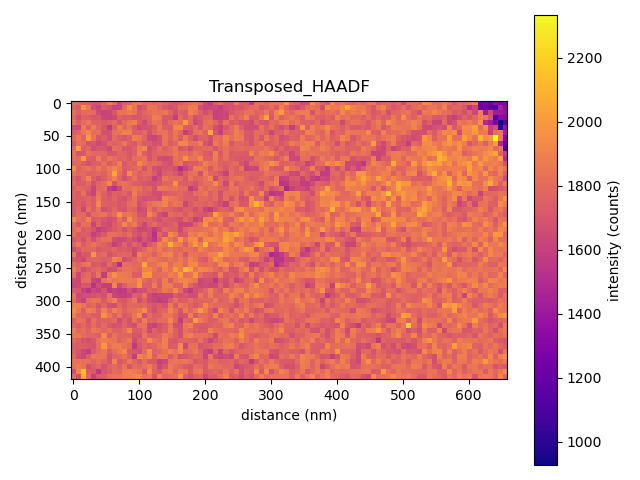

In [4]:
dset = ft.open_file(path + image_path)
image = dset['Channel_000']

view = image.T.plot(cmap='plasma')

### Load 4D-STEM data

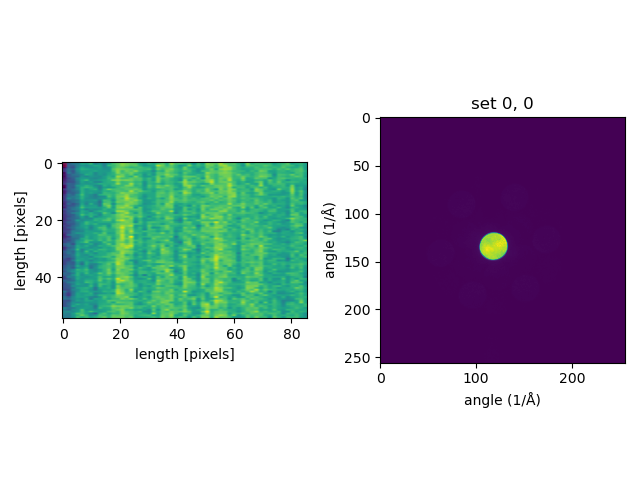

In [9]:
# Initialize
reader = MRCReader(path + cbed_path)

# Read in 4D data
dset = reader.read(handedness='right')
data = dset['Channel_000']

view = data.plot()

### Binning

for this example, we are going to bin the data to DRASTICALLY reduce computation time

I recomend binning until you tune the params, then go back and do a high-fidelity run

In [10]:
# Bin the data in last two dims
data_array = np.array(data)
binned_data = block_reduce(data_array, block_size=(1, 1, 4, 4), func=np.mean)
# Normalize the data (last 2 dims)
binned_data = binned_data / (np.sum(binned_data, axis=(-2, -1), keepdims=True) + 1e-10)

### Pixel sizes (very important for pubications):

In [14]:
pixel_size = image.x.slope
recip_pixel_size = data.u.slope

print(f'Real space pixel size: {pixel_size} nm')
print(f'Reciprocal pixel size: {recip_pixel_size} A^-1')
# yes, it is annoying that the units are different...I'll work on it

Real space pixel size: 7.698929700377791 nm
Reciprocal pixel size: 0.011403936 A^-1


### Shift the zero-disks onto the center of the camera

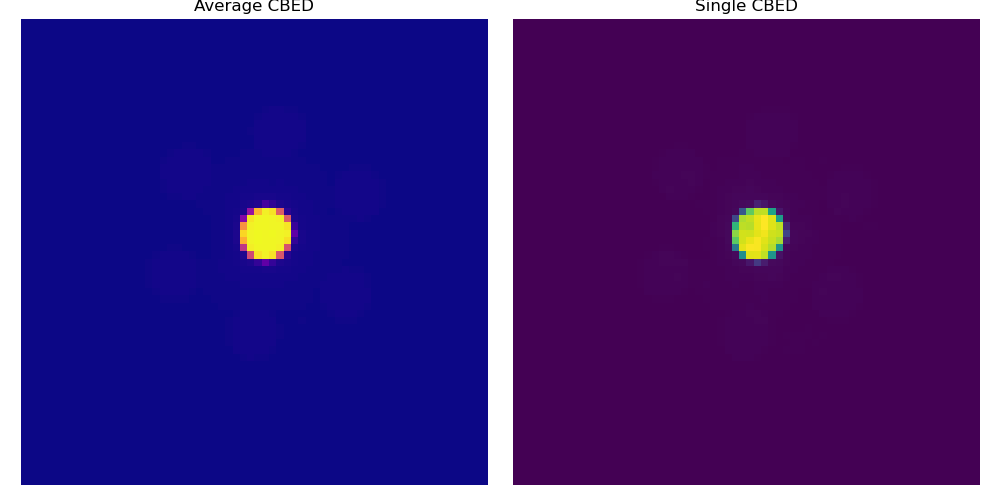

In [17]:
average_cbed = np.mean(binned_data, axis=(0,1))

fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize = (10,5))
ax[0].imshow(average_cbed.T, cmap='plasma')
ax[0].set_title('Average CBED')
ax[1].imshow(binned_data[0,0].T, cmap = 'viridis')
ax[1].set_title('Single CBED')

for a in ax:
    a.axis('off')
fig.tight_layout()

In [16]:
# Compute center of mass of the selected pattern
com = center_of_mass(binned_data[0,0])
desired_center = np.array(binned_data[0,0].shape) / 2  # (32.0, 32.0)
com_shift = desired_center - com
cbed_centered = nd_shift(binned_data[0,0], shift=com_shift, order=3, mode='nearest')

# Preallocate shift arrays
im_dims_x = binned_data.shape[0]
im_dims_y = binned_data.shape[1]
cbed_dims = binned_data.shape[-1]
xshift = np.zeros((im_dims_x, im_dims_y), dtype=np.float32)
yshift = np.zeros((im_dims_x, im_dims_y), dtype=np.float32)

# Flatten the spatial dimensions for fast iteration
binned_data_reshaped = binned_data.reshape(-1, cbed_dims, cbed_dims)

# Iterate over each pattern and compute shift
for idx in tqdm(range(binned_data_reshaped.shape[0]), desc="Aligning"):
    pattern = binned_data_reshaped[idx]
    shift, _, _ = phase_cross_correlation(cbed_centered, pattern, upsample_factor=100)
    y, x = np.unravel_index(idx, (im_dims_x, im_dims_y))
    yshift[y, x] = shift[0]
    xshift[y, x] = shift[1]


Aligning: 100%|██████████| 4730/4730 [00:09<00:00, 496.62it/s]


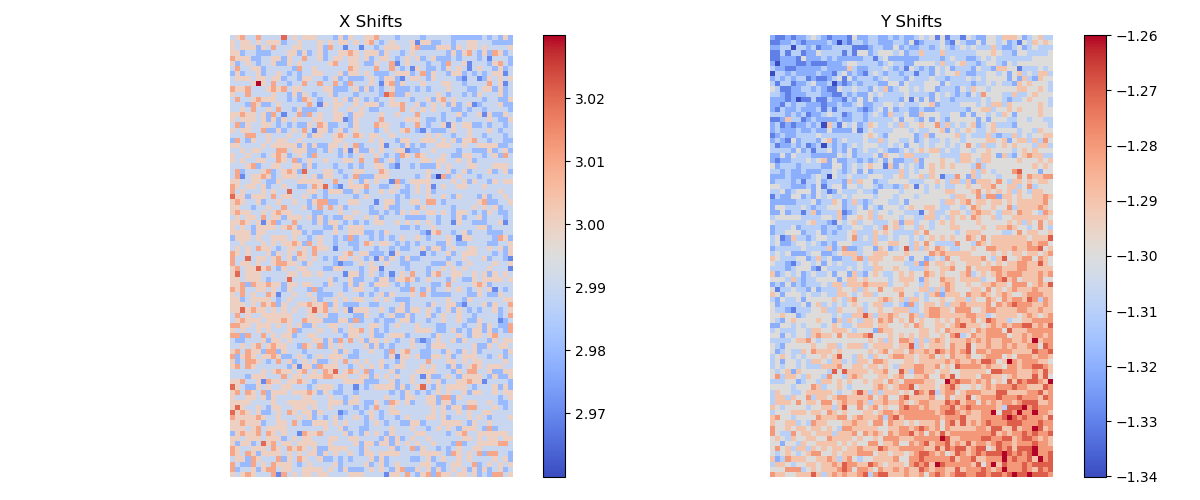

In [18]:
# Reshape shift arrays back 
xshift = xshift.reshape(im_dims_x, im_dims_y)
yshift = yshift.reshape(im_dims_x, im_dims_y)

# Plotting
color_setting = 3
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(xshift.T, cmap='coolwarm')
ax[0].set_title("X Shifts")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(yshift.T, cmap='coolwarm')
ax[1].set_title("Y Shifts")
plt.colorbar(im1, ax=ax[1])

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

In [19]:
# Preallocate the output array
shifted_data = np.empty_like(binned_data)

# Apply shifts with interpolation
for i in tqdm(range(im_dims_x), desc="Shifting rows"):
    for j in range(im_dims_y):
        # Get the shift for this pattern
        dy = yshift[i, j]
        dx = xshift[i, j]

        # Apply shift (with cubic interpolation by default)
        shifted = nd_shift(binned_data[i, j], shift=(dy, dx), order=3, mode='nearest')
        shifted_data[i, j] = shifted

Shifting rows: 100%|██████████| 55/55 [00:01<00:00, 40.35it/s]


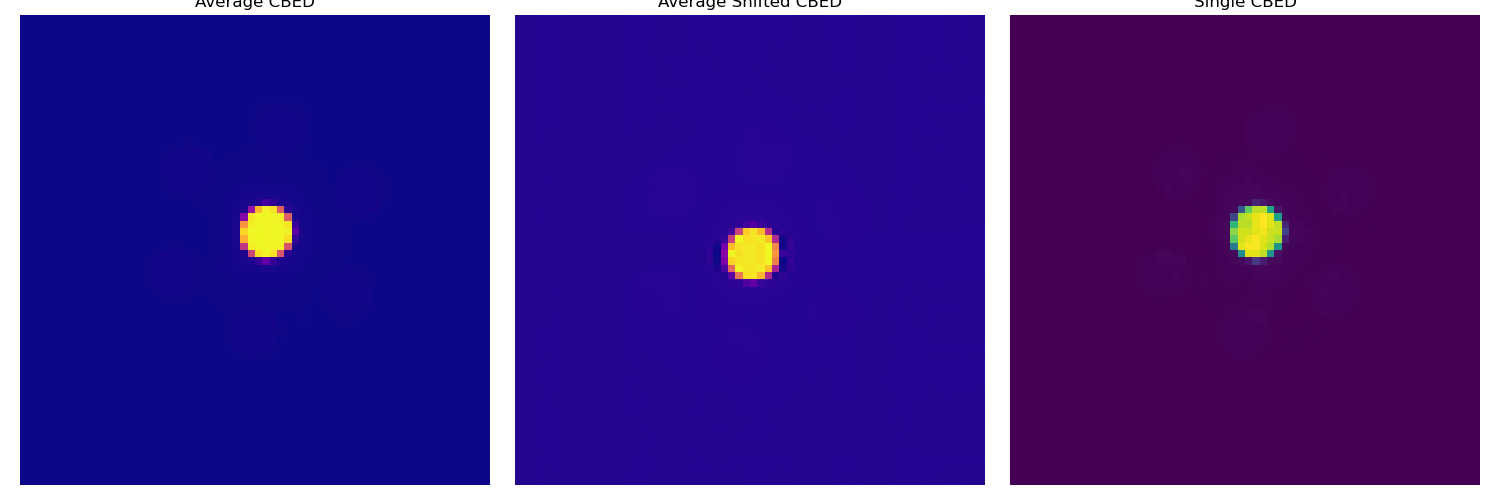

In [20]:
avgerage_shifted_cbed = np.mean(shifted_data, axis=(0,1))

fig, ax = plt.subplots(1,3,sharex=True, sharey=True, figsize = (15,5))

ax[0].imshow(average_cbed.T, cmap='plasma')
ax[0].set_title('Average CBED') 

ax[1].imshow(avgerage_shifted_cbed.T, cmap='plasma')
ax[1].set_title('Average Shifted CBED')

ax[2].imshow(binned_data[0,0].T, cmap = 'viridis')
ax[2].set_title('Single CBED')

for a in ax:
    a.axis('off')
fig.tight_layout()


In [30]:
# normalize it
shifted_data = shifted_data - np.min(shifted_data, axis=(0, 1), keepdims=True)
shifted_data /= shifted_data.max()

### Draw a cirlce over the zero-beam

It's very bright, it's going to throw off all anaysis - but rest in peace

we already aligned all of the zero-beams.  thus we can assume there's no information lost!

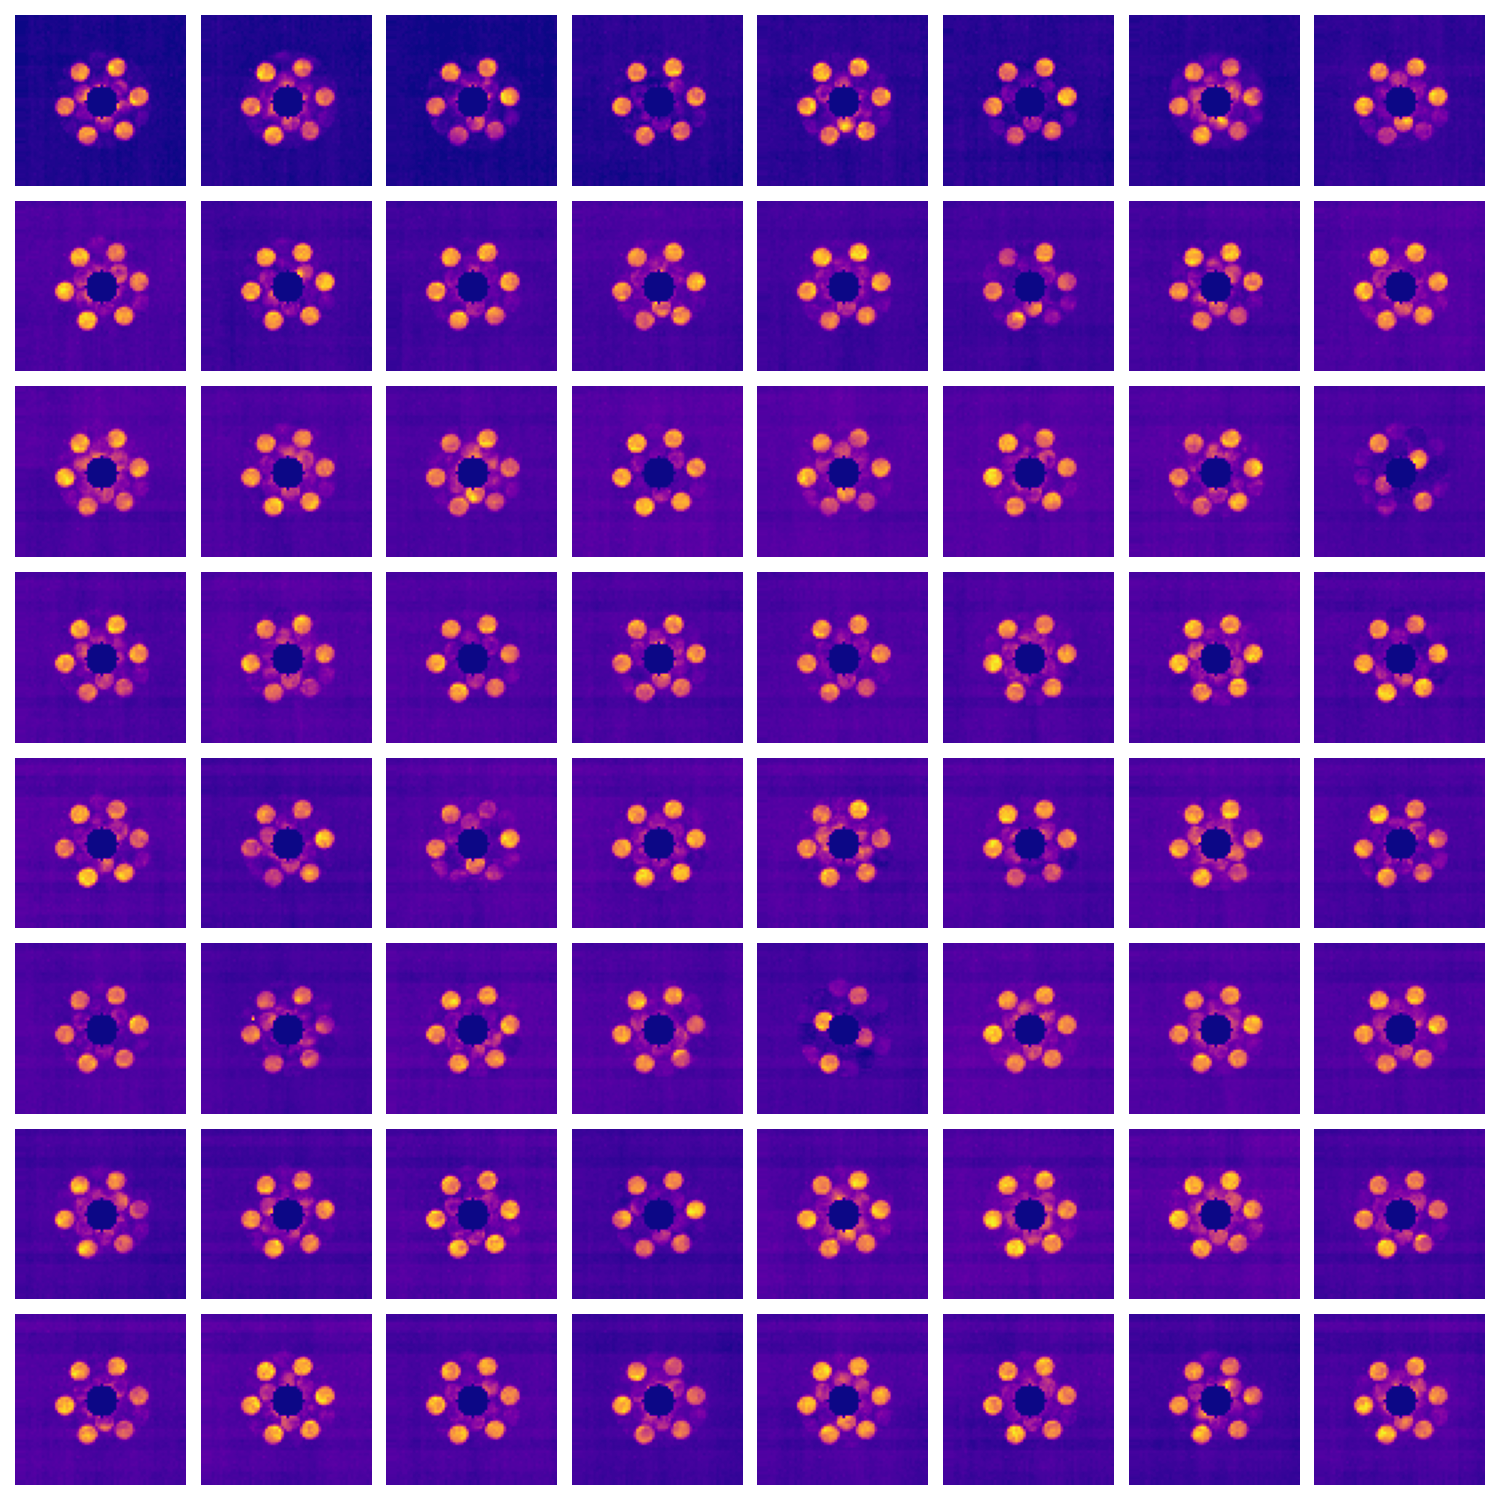

In [33]:
# you may have to change this:
r = 6

# Create a circular mask
diameter = 2 * r + 1
yy, xx = np.ogrid[:diameter, :diameter]
circle_mask = (xx - r)**2 + (yy - r)**2 <= r**2

# Apply the mask to zero out the center of each pattern
masked_data = shifted_data.copy()
n_batches, n_channels, h, w = masked_data.shape
cy, cx = h // 2, w // 2  # assuming each pattern is centered

for b in range(n_batches):
    for c in range(n_channels):
        y_start, y_end = cy - r, cy + r + 1
        x_start, x_end = cx - r, cx + r + 1
        # Bounds check (optional, if dimensions vary)
        if 0 <= y_start and y_end <= h and 0 <= x_start and x_end <= w:
            masked_data[b, c, y_start:y_end, x_start:x_end][circle_mask] = 0
masked_data -= masked_data.min()
masked_data /= masked_data.max()

# visualize
fig, ax = plt.subplots(8,8, sharex=True, sharey=True, figsize=(15,15))
for xi in range(8):
    for yi in range(8):
        ax[xi,yi].imshow(masked_data[7*xi,7*yi], cmap='plasma')#, vmin=0.05, vmax=0.18)
        ax[xi,yi].axis('off')
fig.tight_layout()

### Edge crops

You'll notice the dark edges where the haadf cuts off the beam past some angle.

no need to do computations on these zero-information regions

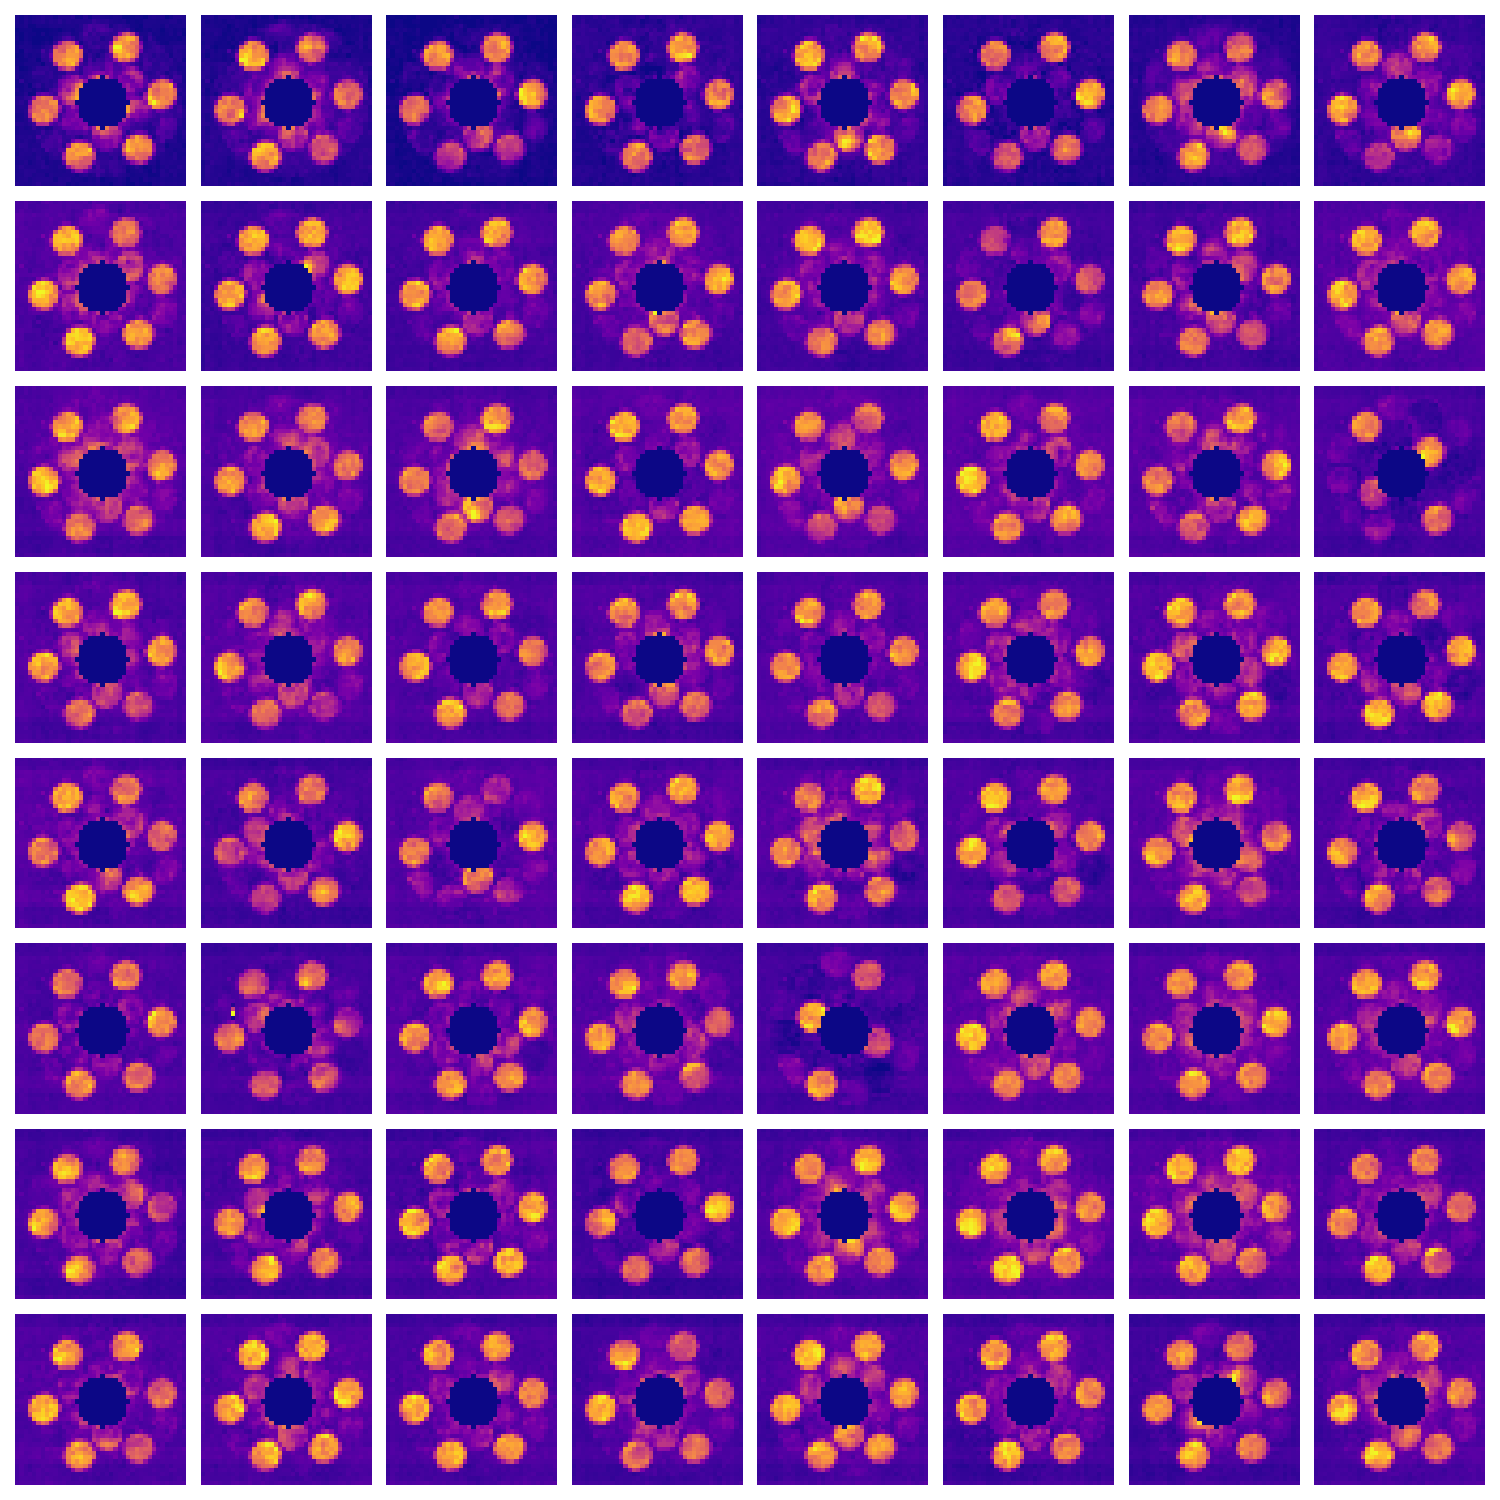

In [35]:
edge_crop = 12
norm_data = masked_data[:,:,edge_crop:-edge_crop, edge_crop:-edge_crop]

# visualize
fig, ax = plt.subplots(8,8, sharex=True, sharey=True, figsize=(15,15))
for xi in range(8):
    for yi in range(8):
        ax[xi,yi].imshow(norm_data[7*xi,7*yi], cmap='plasma')#, vmin=0.05, vmax=0.18)
        ax[xi,yi].axis('off')
fig.tight_layout()

In [37]:
norm_data_shape = norm_data.shape
norm_data_shape

(55, 86, 40, 40)

### NMF to clean the data

Non-negative Matrix Factorization (NMF)

We find the 8 best components that describe the data

Then, we reconstruct the data using only these components

In [52]:
norm_data_flat = norm_data.reshape(-1, norm_data.shape[-2] * norm_data.shape[-1])
norm_data_flat = np.nan_to_num(norm_data_flat, nan=0.0)

n_components = 8
nmf = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter=2000)
W = nmf.fit_transform(norm_data_flat)  # shape: (num_valid_pixels, n_components)
H = nmf.components_                 # shape: (n_components, 1024)

W_reshaped = W.reshape(norm_data.shape[0], norm_data.shape[1], n_components)
H_reshaped = H.reshape(n_components, norm_data.shape[-2], norm_data.shape[-1])
print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")


Reconstruction error: 43.5228


/Users/austin/miniconda3/envs/pytemlib_2025/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


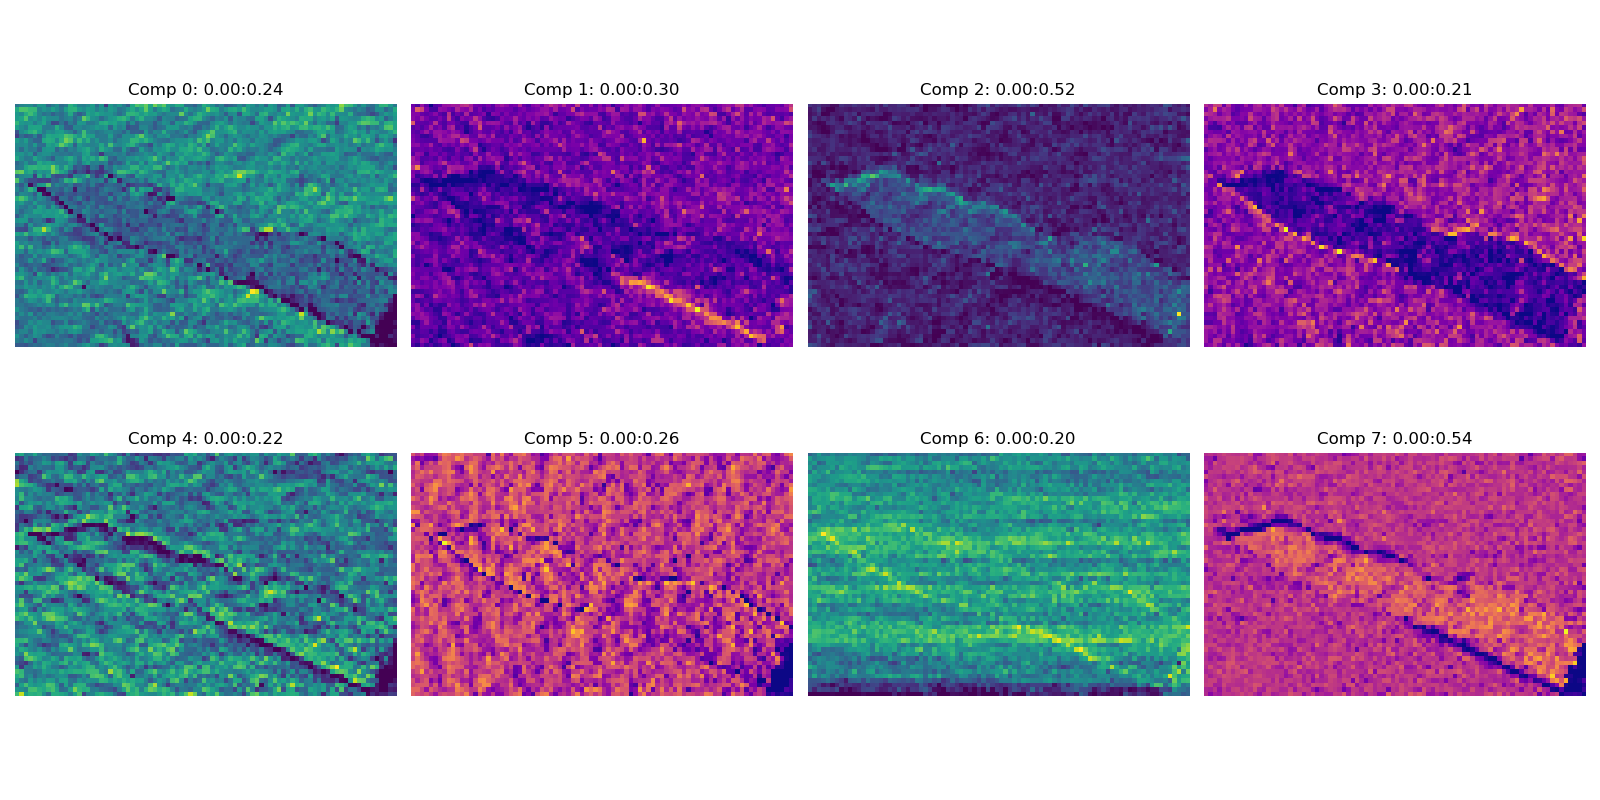

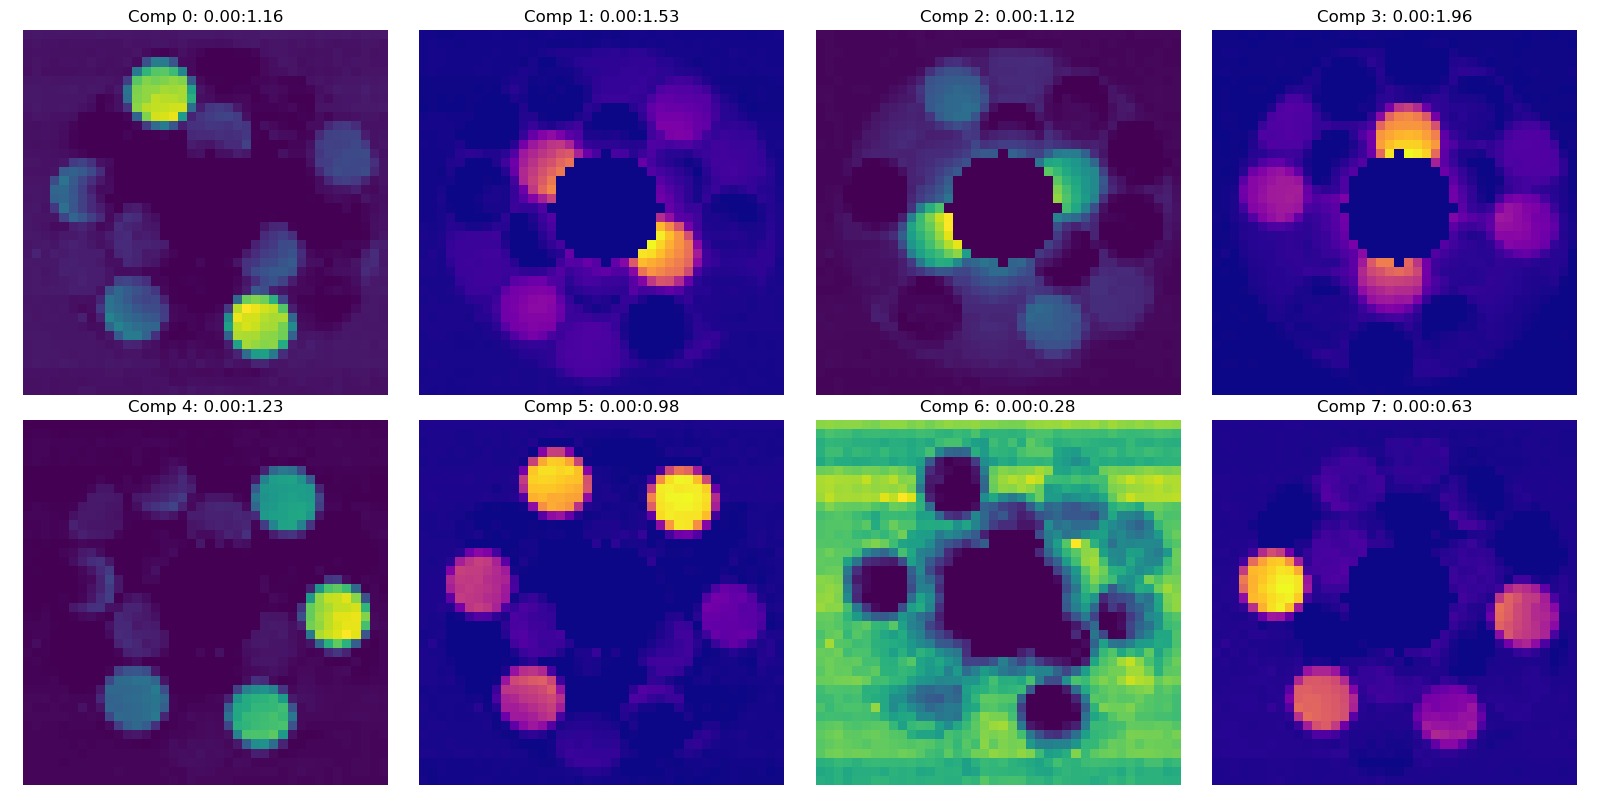

In [55]:
# Step 7: Visualize real-space activations (W)
cmaps = ['viridis', 'plasma'] * 8  # repeating pattern of colormaps
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(image, cmap='grey')
    ax[i].imshow(W_reshaped[:, :, i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'Comp {i}: {np.nanmin(W_reshaped[:,:,i]):.2f}:{np.nanmax(W_reshaped[:,:,i]):.2f}')

plt.tight_layout()
# Step 8: Visualize component patterns (H)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.ravel()
for i in range(n_components):
    ax[i].imshow(H_reshaped[i], cmap=cmaps[i], origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'Comp {i}: {H_reshaped[i].min():.2f}:{H_reshaped[i].max():.2f}')
plt.tight_layout()


### NMF Reconstruction

look how clean it is!

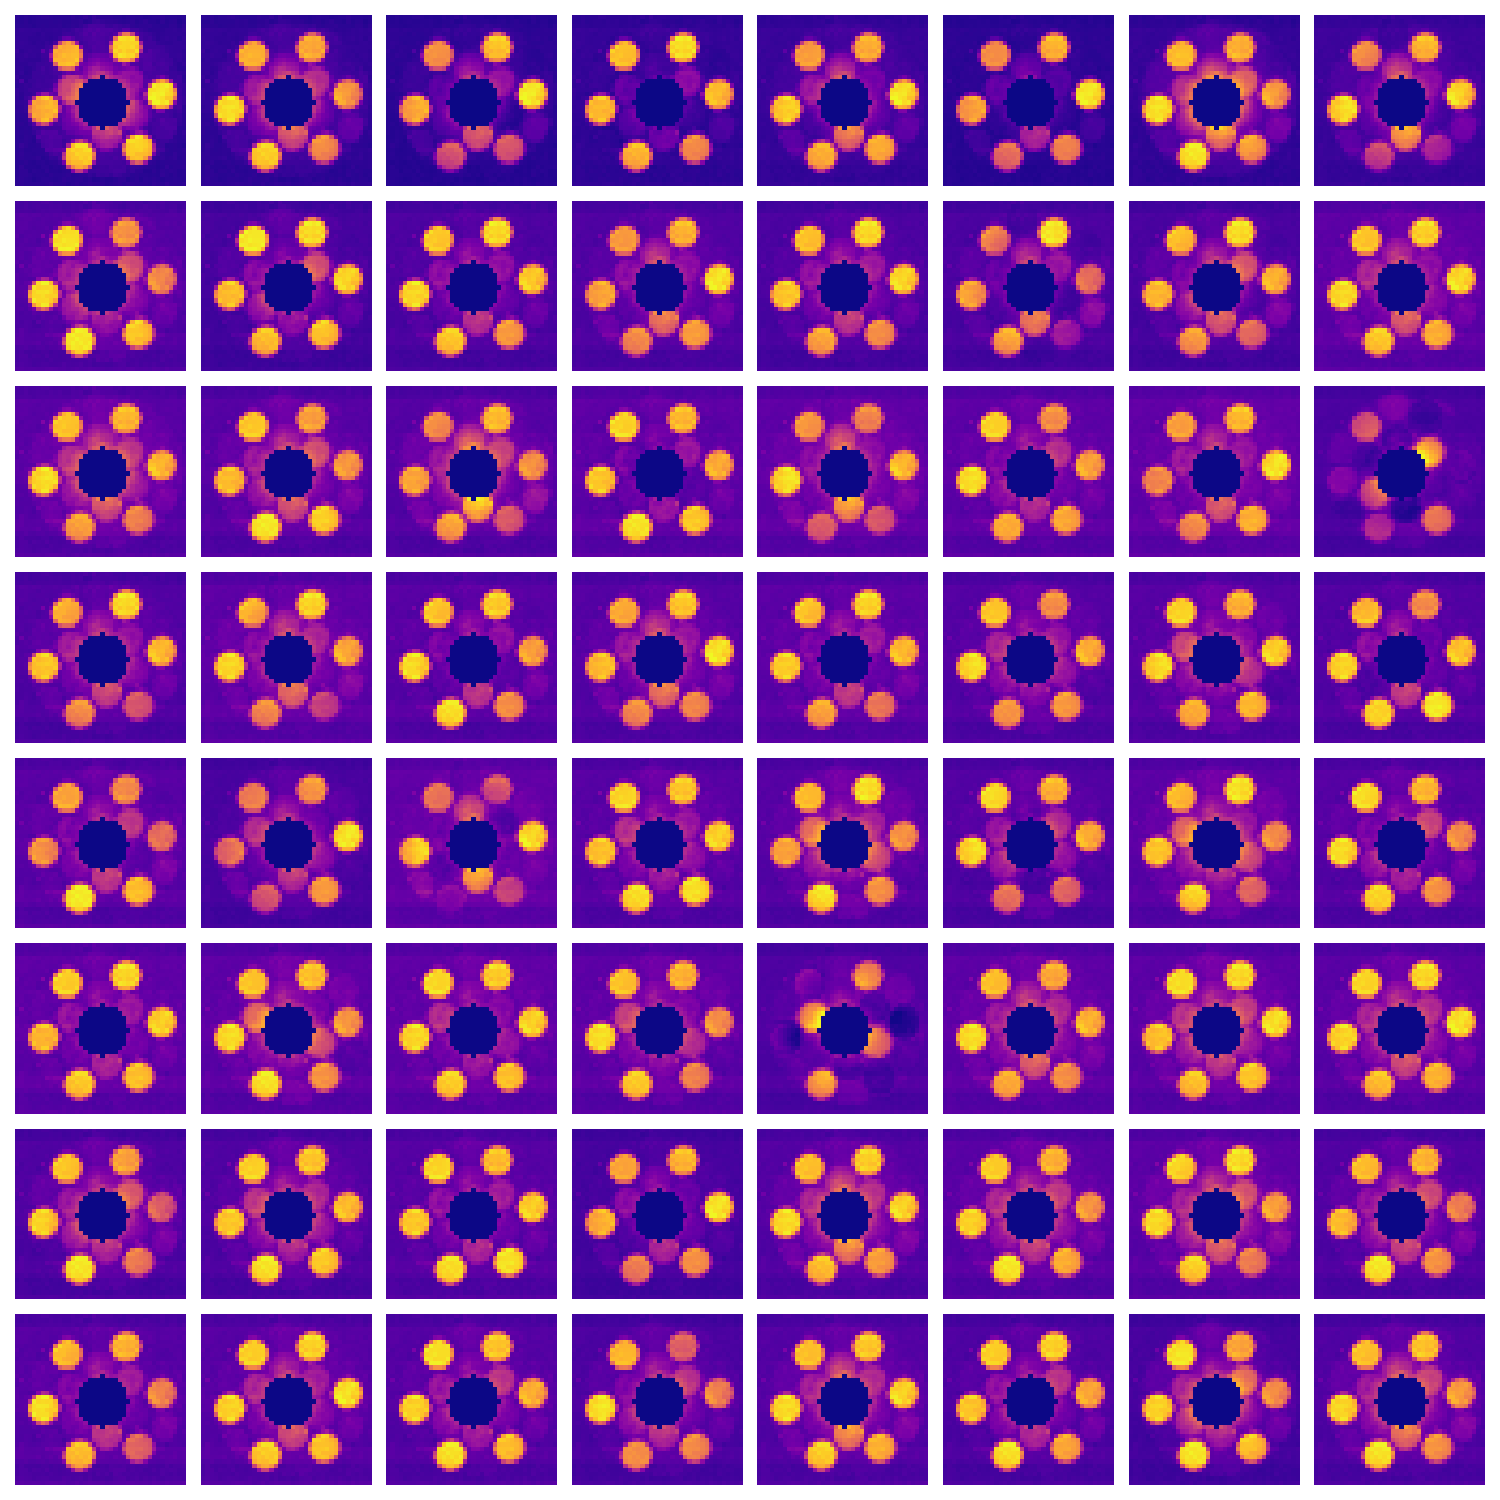

In [60]:
reconstruction = np.dot(W_all, H) # W_all or W_reshaped
reconstruction = reconstruction.reshape(norm_data.shape)

# visualize
fig, ax = plt.subplots(8,8, sharex=True, sharey=True, figsize=(15,15))
for xi in range(8):
    for yi in range(8):
        ax[xi,yi].imshow(reconstruction[7*xi,7*yi], cmap='plasma')#, vmin=0.05, vmax=0.18)
        ax[xi,yi].axis('off')
fig.tight_layout()

### K-Means Clustering

In [71]:
# first, reshape appropriately
kmeans_data = reconstruction.copy()
kmeans_data = kmeans_data.reshape(-1, kmeans_data.shape[-2], kmeans_data.shape[-1])
kmeans_data = kmeans_data.reshape(-1, kmeans_data.shape[-2]*kmeans_data.shape[-1])
kmeans_data = np.nan_to_num(kmeans_data, nan=0.0)

# now, cluster
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(kmeans_data)


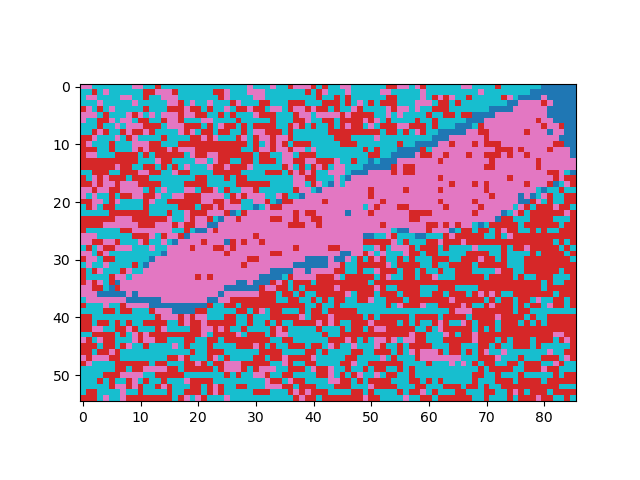

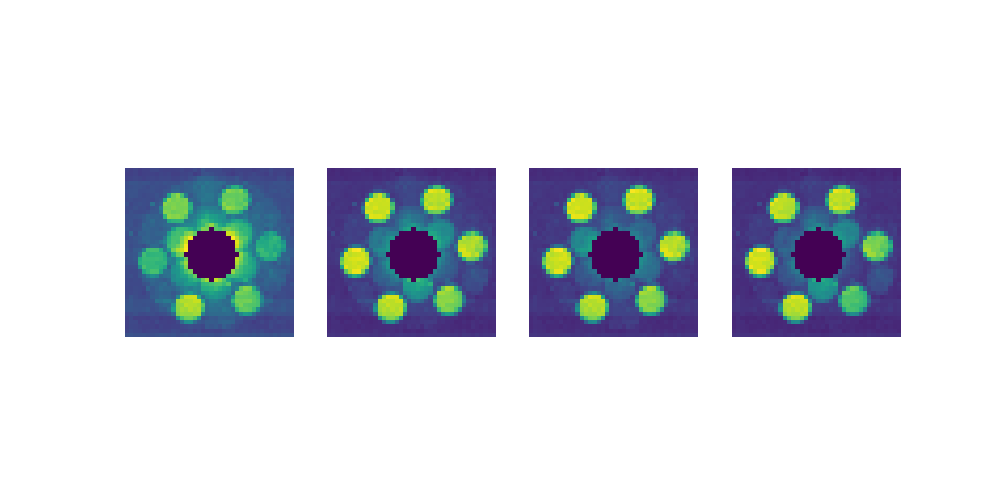

In [72]:
# now, reshape back
labels = kmeans.labels_
labels = labels.reshape(reconstruction.shape[0], reconstruction.shape[1])
plt.figure()
plt.imshow(labels, cmap='tab10')

# view the cluster centers
centers = kmeans.cluster_centers_
centers = centers.reshape(n_clusters, norm_data_shape[-2], norm_data_shape[-1])
fig, ax = plt.subplots(1, n_clusters, figsize=(10, 5))
for i in range(n_clusters):
    ax[i].imshow(centers[i])
    ax[i].axis('off')